# Numerical Accuracy of Task phaseshift
Original author: dmehring@nrao.edu


## Description

This notebook demonstrates the determination of the numercial accuracy of task **phaseshift**.
Much of the simulation-related code is adapted from that of rurvashi 
https://gitlab.nrao.edu/rurvashi/simulation-in-casa-6/-/blob/master/Simulation_Script_Demo.ipynb

In [1]:
import os

print("installing pre-requisite packages...")
os.system("pip install scipy matplotlib")

print("installing casa...")
# make sure there is a version that contains phaseshift
os.system("pip install casatasks==6.3.0.48")
os.system("pip install casadata")
print("complete")


installing pre-requisite packages...
installing casa...
complete


In [2]:
# imports and set globals

from casatools import componentlist, ctsys, measures, quanta, simulator
from casatasks import flagdata, imfit, imstat, phaseshift, tclean
from casatasks.private import simutil
import glob
import os
import shutil

cl = componentlist()
me = measures()
qa = quanta()
sm = simulator()

comp_list = 'sim_onepoint.cl'
orig_ms = 'sim_data.ms'
orig_im = 'im_orig'
pshift_ms = 'sim_data_pshift.ms'
pshift_im = 'im_post_phaseshift'
tshift_im = 'im_post_tclean_shift'
# simulated source flux density
exp_flux = 5


In [3]:
def cleanup():
  """clean up from any previous runs"""
  for f in (comp_list, orig_ms, pshift_ms):
    if os.path.exists(f):
      shutil.rmtree(f)
  for x in (orig_ms, orig_im, pshift_im, tshift_im):
    for path in glob.glob(x + '.*'):
      shutil.rmtree(path)

In [4]:
def __direction_string(ra, dec, frame):
  """helper function for often needed string"""
  return ' '.join([frame, ra, dec])

In [5]:
def __makeMSFrame(antenna_file, spwname, freq, radir, decdir, dirframe):
  """
  Construct an empty Measurement Set that has the desired
  observation setup.
  """
  # Open the simulator
  sm.open(ms=orig_ms)
  # Read/create an antenna configuration.
  # Canned antenna config text files are located at
  # /home/casa/data/trunk/alma/simmos/*cfg
  # antennalist = os.path.join(ctsys.resolve("alma/simmos"), "vla.d.cfg")
  # Fictitious telescopes can be simulated by specifying x, y, z, d,
  # an, telname, antpos.
  # x,y,z are locations in meters in ITRF (Earth centered)
  # coordinates.
  # d, an are lists of antenna diameter and name.
  # telname and obspos are the name and coordinates of the
  # observatory.
  (x, y, z, d, an, an2, telname, obspos) = (
    simutil.simutil().readantenna(antenna_file)
  )
  # Set the antenna configuration
  sm.setconfig(
  telescopename=telname, x=x, y=y, z=z, dishdiameter=d,
  mount=['alt-az'], antname=an, coordsystem='global',)
  referencelocation=me.observatory(telname)
  # Set the polarization mode (this goes to the FEED subtable)
  sm.setfeed(mode='perfect R L', pol=[''])
  # Set the spectral window and polarization (one
  # data-description-id).
  # Call multiple times with different names for multiple SPWs or
  # pol setups.
  sm.setspwindow(
    spwname=spwname, freq=freq, deltafreq='0.1GHz',
    freqresolution='0.2GHz', nchannels=1, stokes='RR LL'
  )
  # Setup source/field information (i.e. where the observation phase
  # center is) Call multiple times for different pointings or source
  # locations.
  sm.setfield(
    sourcename="fake", sourcedirection=me.direction(
      rf=dirframe, v0=radir, v1=decdir
    )
  )
  # Set shadow/elevation limits (if you care). These set flags.
  sm.setlimits(shadowlimit=0.01, elevationlimit='1deg')
  # Leave autocorrelations out of the MS.
  sm.setauto(autocorrwt=0.0)
  # Set the integration time, and the convention to use for timerange
  # specification
  # Note : It is convenient to pick the hourangle mode as all times
  # specified in sm.observe() will be relative to when the source
  # transits.
  sm.settimes(
    integrationtime='60s', usehourangle=True,
    referencetime=me.epoch('UTC', '2019/10/4/00:00:00')
  )
  # Construct MS metadata and UVW values for one scan and ddid
  # Call multiple times for multiple scans.
  # Call this with different sourcenames (fields) and spw/pol
  # settings as defined above.
  # Timesteps will be defined in intervals of 'integrationtime',
  # between starttime and stoptime.
  sm.observe(
    sourcename="fake", spwname=spwname, starttime='-5.0h',
    stoptime='+5.0h'
  )
  # Close the simulator
  sm.close()
  # Unflag everything (unless you care about elevation/shadow flags)
  flagdata(vis=orig_ms, mode='unflag')

In [6]:
def __makeCompList(ra, dec, frame):
  """make a componentlist of point sources"""
  # Add sources, one at a time.
  # Call multiple times to add multiple sources.
  # ( Change the 'dir', obviously )
  cl.addcomponent(
    dir=__direction_string(ra, dec, frame),
    flux=exp_flux,
    fluxunit='Jy', freq='1.5GHz', shape='point',
    spectrumtype="constant"
  )
  # Save the file
  cl.rename(filename=comp_list)
  cl.done()

In [7]:
def __predictSimFromComplist():
  sm.openfromms(orig_ms)
  # Predict from a component list
  sm.predict(complist=comp_list, incremental=False)
  sm.close()

In [8]:
def __summarize(imagename, imfit_box, sim_source_dir, label, prec):
  # get the image statistics, and print the world coordinates of the maxposf,
  # and note that they are within one 8" pixel of the simulated source position,
  # as expected.
  x = imstat(imagename)
  # to be even more accurate, fit a 2-D gaussian to the source to show that, to
  # approximately within the fit errors, the position is coincident to the
  # expected position
  y = imfit(imagename, box=imfit_box)
  poserr = y['deconvolved']['component0']['shape']['direction']['error']
  print(label)
  print('Simulated source position', sim_source_dir)
  print("coordinates of max position from imstat", x['maxposf'])
  cl.fromrecord(y['deconvolved'])
  rd = cl.getrefdir(0)
  cl.done()
  ra_err = qa.div(
    qa.div(qa.quantity(poserr['longitude']), 15),
    qa.cos(qa.quantity(rd['m1']))
  )
  ra_err['unit'] = 's'
  dec_err = qa.quantity(poserr['latitude'])
  print(
    "fitted position from imfit",
    qa.time(qa.totime(qa.quantity(rd['m0'])), prec=6+prec, form='hms')[0], '\u00b1',
    qa.tos(ra_err, prec=prec),
    qa.angle(qa.totime(qa.quantity(rd['m1'])), prec=6+prec)[0], '\u00b1',
    qa.tos(dec_err, prec=prec),
  )

In [9]:
def verify():
  def __create_input_ms():
    """create the input MS"""
    __makeMSFrame(antenna_file, spwname, freq, fra, fdec, fframe)
    # Make the component list
    __makeCompList(radir, decdir, dirframe)
    # Predict Visibilities
    __predictSimFromComplist()

  for observatory in ('VLA', 'ALMA'):
    cleanup()
    print(observatory, 'simulation:')
    # This is the source position
    if observatory == 'VLA':
      radir = '19h49m43'
      decdir = '38d45m15'
      dirframe = 'J2000'
      ant_cfg = "vla.d.cfg"
      spwname = 'LBand'
      freq = '1.0GHz'
      cell = '8.0arcsec'
      imfit_box = '1870, 165, 1890, 185'
      prec = 3
    elif observatory == 'ALMA':
      radir = '19h59m33.2'
      decdir = '40d40m53.2'
      dirframe = 'J2000'
      antenna_file = ant_cfg = 'alma.cycle8.8.cfg'
      spwname = 'Band4'
      freq = '150GHz'
      cell = '0.06arcsec'
      imfit_box = '123, 1876, 143, 1896'
      prec = 5
    antenna_file = os.path.join(ctsys.resolve("alma/simmos"), ant_cfg)
    dirstring = __direction_string(radir, decdir, dirframe)
    # this is the original phase center
    fra = '19h59m28.5'
    fdec = '+40.40.01.5'
    fframe = 'J2000'
    print("Create the simulated MS.\n")
    __create_input_ms()
    print(
      "Image simulated MS with no phase shift. The source is offset from\n"
      "the phase center of the image. We use wproject and wprojplanes\n"
      "to correctly account for the non-negligible values of the w\n"
      "coordinate because the source is far from the phase center.\n"
    )
    tclean(
      vis=orig_ms, imagename=orig_im, datacolumn='data',
      imsize=2048, cell=cell, gridder='wproject',
      niter=20, gain=0.2, wprojplanes=128, pblimit=-0.1
    )
    print("Summarize results:\n")
    __summarize(
      orig_im + '.image', imfit_box, dirstring, 'Image with no shift applied', 5
    )
    print(
        "\nNow use phaseshift to shift the phase center of the\n"
        "MS to the source position.\n"
    )
    phaseshift(vis=orig_ms, outputvis=pshift_ms, phasecenter=dirstring)
    print(
        "Image the phase shifted MS. The image can be significantly\n"
        "smaller because the source will now be at the image center.\n"
    )
    tclean(
      vis=pshift_ms, imagename=pshift_im, datacolumn='data',
      imsize=256, cell=cell, gridder='wproject',
      niter=20, gain=0.2, wprojplanes=128, pblimit=-0.1
    )
    print("Summarize the results:\n")
    __summarize(
      pshift_im + '.image', '118, 118, 138, 138', dirstring,
      'Phase shifted image using phaseshift to set the phase center', prec + 3
    )
    print("\nNow image the original, unshifted MS using a phase shift in tclean\n")
    tclean(
      vis=orig_ms, imagename=tshift_im, datacolumn='data',
      imsize=256, cell=cell, gridder='wproject',
      niter=20, gain=0.2, wprojplanes=128, pblimit=-0.1,
      phasecenter=__direction_string(radir, decdir, dirframe)
    )
    print("Summarize the results\n")
    __summarize(
      tshift_im + '.image', '118, 118, 138, 138', dirstring,
      'Phase shifted image using tclean to set phase center', prec + 3
    )
    print()


In [10]:
if __name__ == '__main__':
  verify()

VLA simulation:
Create the simulated MS.

Image simulated MS with no phase shift. The source is offset from
the phase center of the image. We use wproject and wprojplanes
to correctly account for the non-negligible values of the w
coordinate because the source is far from the phase center.

Summarize results:

Image with no shift applied
Simulated source position J2000 19h49m43 38d45m15
coordinates of max position from imstat 19:49:42.907, +38.45.13.185, I, 999980842.28Hz
fitted position from imfit 19:49:42.99118 ± 0.01171s +038.45.15.21608 ± 0.10346arcsec

Now use phaseshift to shift the phase center of the
MS to the source position.

Image the phase shifted MS. The image can be significantly
smaller because the source will now be at the image center.

Summarize the results:

Phase shifted image using phaseshift to set the phase center
Simulated source position J2000 19h49m43 38d45m15
coordinates of max position from imstat 19:49:43.000, +38.45.15.000, I, 999983449.88Hz
fitted positio

## Overview
The script performs two simulations, the first based on the VLA and the second based on ALMA.
For each, an MS is created using the simulator tool. In order to make the verification process
more transparent, no noise is introduced into the simulated data. The visibilities are then
predicted using a 5 Jy point source that has a significant offset (so that the w coordinate is non-
negligible) from the phase center. The MS is imaged by tclean using no phase center shift, to
illustrate that the source is indeed significantly offset from the phase center. Because proper
account of the w coordinate must be made, gridder=’wproject’ and wprojectplanes are set in
tclean. The peak pixel coordinates are computed via the task imstat and a two dimensional
Gaussian fit using the task imfit is performed to further constrain the source position to illustrate
that it is indeed located at the coordinates specified when creating the MS. The phaseshift task is
then run on the original MS, shifting the phase center to the position of the source. The resulting
MS is imaged using tclean. Both imstat and imfit are run as before to verify the source
coordinates. Finally, tclean is run using the original MS and specifying the phasecenter
parameter to be coincident with the source position, to illustrate that tclean can also properly
shift the phase center. Results, described in the next sections, indicate that both phaseshift and
tclean properly shift the phase center to within a small fraction of a pixel, and that phaseshift is
slightly more accurate, although both are very close to the expected result.

## Results
The output of the script, when run on an RHEL 7 machine, is
### VLA simulation
Image with no shift applied:
```
Simulated source position: J2000 19h49m43 38d45m15
coordinates of max position from imstat: 19:49:42.907, +38.45.13.185, I, 999980842.28Hz
fitted position from imfit 19:49:42.99118 ± 0.01171s +038.45.15.21608 ± 0.10346arcsec
```
Phase shifted image using phaseshift to set the phase center:

```
Simulated source position J2000 19h49m43 38d45m15
coordinates of max position from imstat 19:49:43.000, +38 45.15.000, I, 999983449.88Hz
fitted position from imfit 19:49:43.000008 ± 0.001796s +038.45.14.999908 ± 0.016103arcsec
```
Phase shifted image using tclean to set phase center:
```
Simulated source position J2000 19h49m43 38d45m15
coordinates of max position from imstat 19:49:43.000, +38.45.15.000, I, 999980842.28Hz
fitted position from imfit 19:49:42.989652 ± 0.001851s +038.45.14.869487 ± 0.016600arcsec
```

### ALMA simulation
Image with no shift applied:
```
Simulated source position J2000 19h59m33.2 40d40m53.2
coordinates of max position from imstat 19:59:33.200, +40.40.53.214, I, 1.49997e+11Hz
fitted position from imfit 19:59:33.20002 ± 0.00002s +040.40.53.20107 ± 0.00038arcsec
```
Phase shifted image using phaseshift to set the phase center:
```
Simulated source position J2000 19h59m33.2 40d40m53.2
coordinates of max position from imstat 19:59:33.200, +40.40.53.200, I, 1.49997e+11Hz
fitted position from imfit 19:59:33.20000000 ± 0.00000442s +040.40.53.19999711 ± 0.00007270arcsec
```
Phase shifted image using tclean to set phase center:
```
Simulated source position J2000 19h59m33.2 40d40m53.2
coordinates of max position from imstat 19:59:33.200, +40.40.53.200, I, 1.49997e+11Hz
fitted position from imfit 19:59:33.20007214 ± 0.00000593s +040.40.53.20079661 ± 0.00009744arcsec
```
## VLA Simulation Details
The VLA simulation uses antenna positions in the D configuration and a frequency of 1.0 GHz.
The resulting images have 8.0” pixels. The phase center and the source in the original MS were
separated by about 2.7 degrees. Figure 1 shows the full image created from the original MS. The
point source can be seen in the lower right corner of the image. Figure 2 shows the image created
from the MS after running phaseshift to shift the phase center to the position of the source. The
contours represent the image created from the original MS, using tclean to shift the phase center
to the source position using the phasecenter parameter. Figure 3 is the central portion of Figure 2.The results (see above) indicate that source position in the image that is not phase shifted is
indeed as expected. The somewhat large fit errors are likely due to the fact that the source is not
located at the center of a pixel. The results for the image created from the MS that has been
produced by phaseshift show excellent agreement with the expected source position. The fit
uncertainty provides an upper limit of about 30 marcsec (0.003 pixels) of the offset of the source
from the phase center, and the best fit results are two orders of magnitude better than that at about
0.1 marcsec (0.00002 pixels). The results of the image created from the unshifted MS by
applying the phase shift in tclean using the phasecenter parameter are also very good, although
not as good as the image made from the MS created using phaseshift. In this case, the offset
between source and phase center falls significantly outside the fit uncertainty, with a separation of
about 0.2arcsec (0.02 pixels).

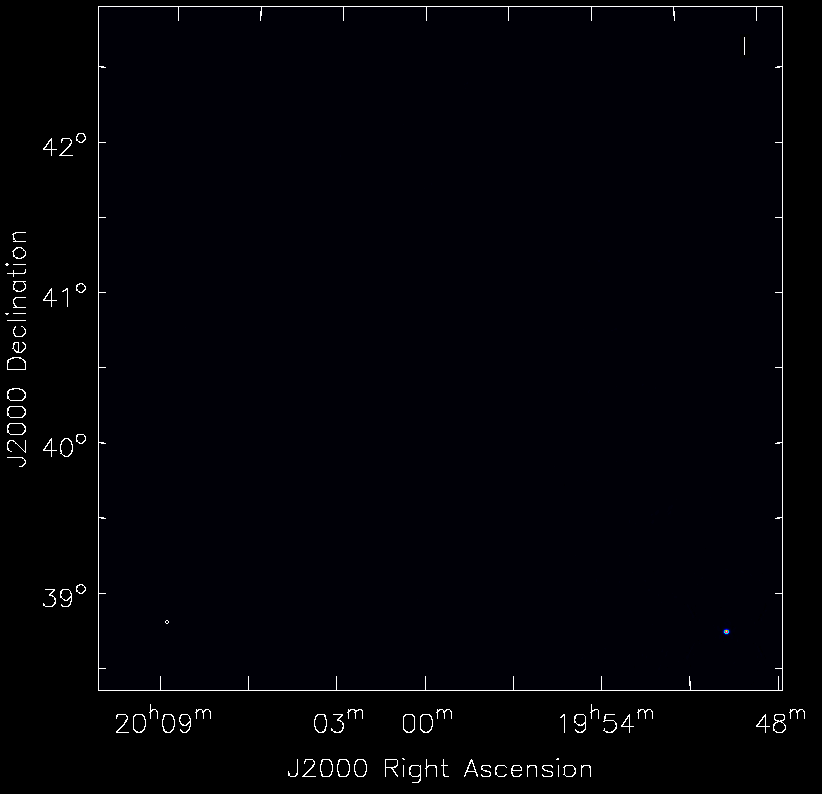

Figure 1: VLA simulated data image prior to phase shift. The source is in the lower right corner.

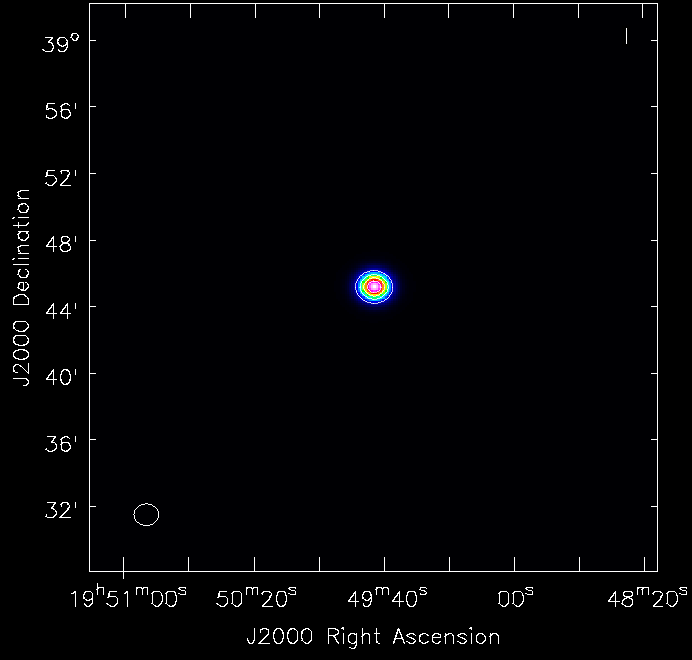

Figure 2: VLA simulated data full image after running phaseshift. The contours
represent the image created by setting the phasecenter parameter in tclean.

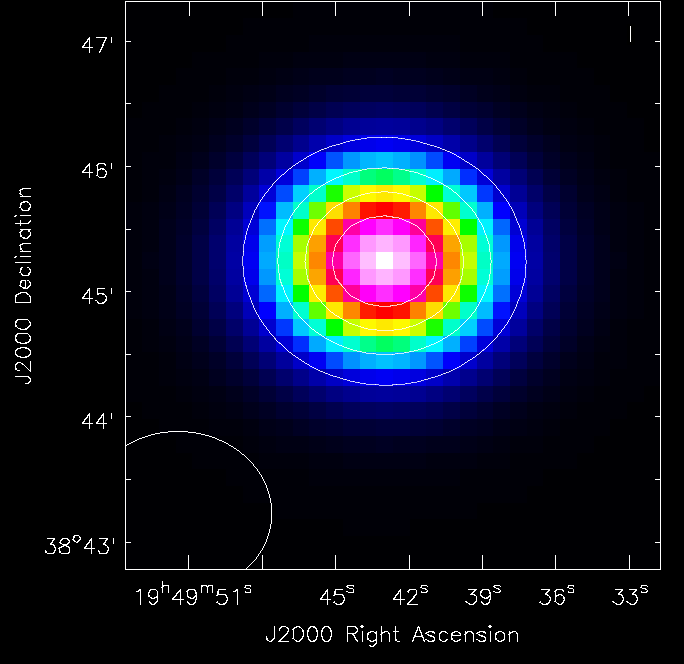

Figure 3: VLA simulated data image central portion after running phaseshift. The
contours represent the image created by setting the phasecenter parameter in tclean.

### ALMA Simulation Details

The ALMA simulation uses antenna positions in the eighth configuration of cycle 8 and a
frequency of 150 GHz. The resulting images have 60 marcsec pixels. The phase center and the
source in the original MS were separated by about 1.2 arcmin. Figure 4 shows the full image
created from the original MS. The point source can be seen in the upper left corner of the image.
Figure 5 shows the image created from the MS after running phaseshift to shift the phase center
to the position of the source. The contours represent the image created from the original MS, and
using tclean to shift the phase center to the source position using the phasecenter parameter.
Figure 6 is the central portion of Figure 5.
The results (see above) indicate that source position in the image that is not phase shifted is
indeed as expected. The somewhat large fit errors are likely due to the fact that the source is not
located at the center of a pixel. The results for the image created from the MS that has been
produced by phaseshift show excellent agreement with the expected source position. The fit
uncertainty provides an upper limit of about 90 μarcsec (0.001 pixels) of the offset of the sourcefrom the phase center, and the best fit results are an order of magnitude better than that at about 3
μarcsec (0.00005 pixels). The results of the image created from the unshifted MS by applying the
phase shift in tclean using the phasecenter parameter are also very good, although not as good as
the image made from the MS created using phaseshift. In this case, the offset between source
and phase center falls significantly outside the fit uncertainty, with a separation of about 1
marcsec (0.02 pixels).

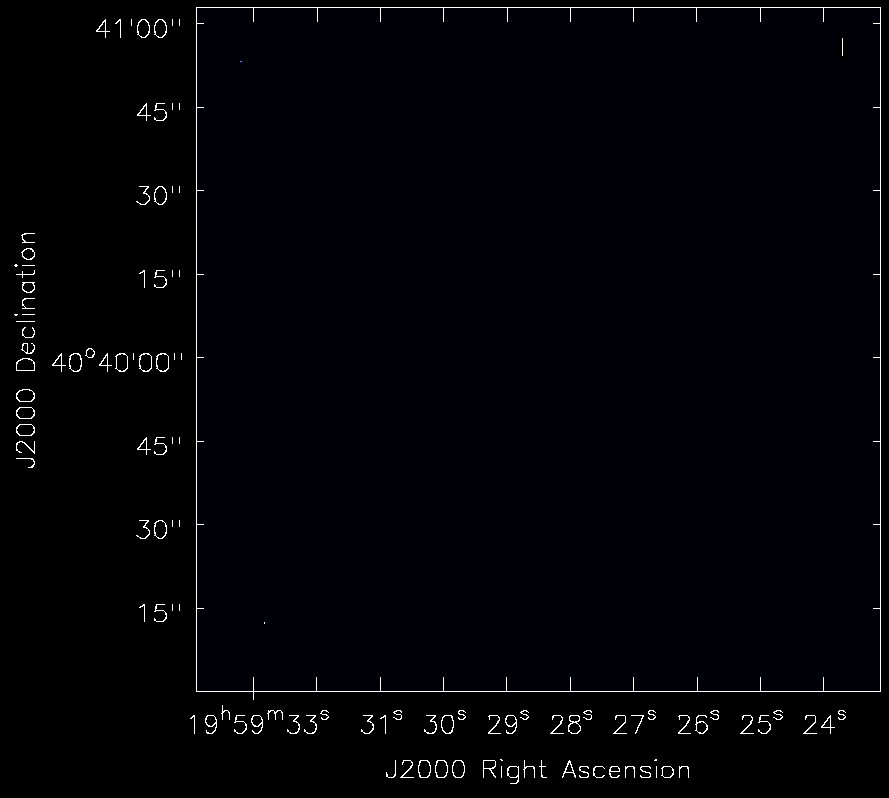

Figure 4: ALMA simulated data image prior to phase shift. The source is in the upper left corner.

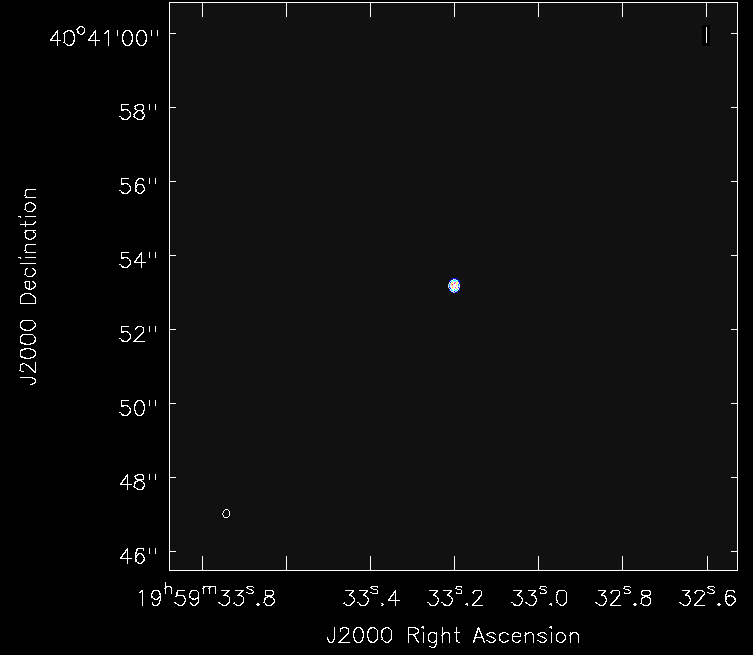

Figure 5: ALMA simulated data full image after running phaseshift. The contours represent
the image created by setting the phasecenter parameter in tclean.

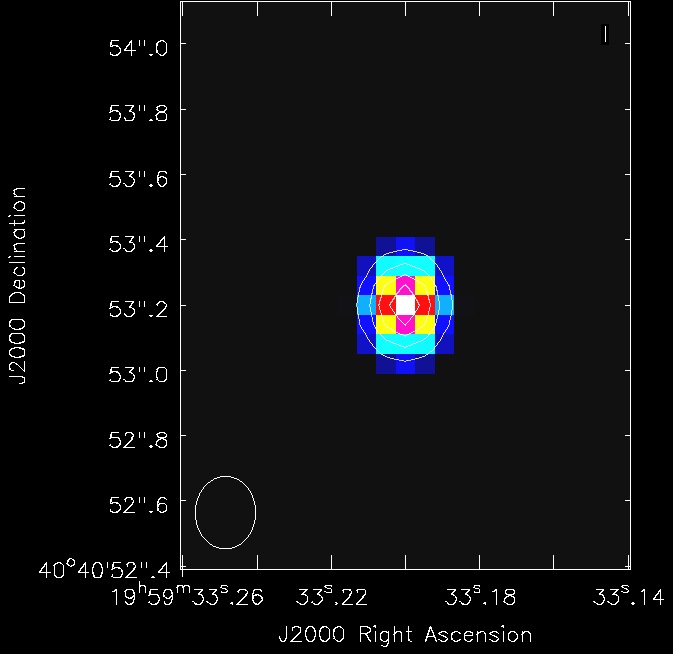

Figure 6: ALMA simulated data image central portion after running phaseshift.
The contours represent the image created by setting the phasecenter parameter in
tclean.